## Image Classification on CIFAR-10 with Hydra and TorchFlare
* Dataset : <https://www.kaggle.com/c/cifar-10>
* Hydra:cc : <https://github.com/facebookresearch/hydra>


In [1]:
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import *

In [2]:
import torch 
from torchflare.datasets import ImageDataloader , show_batch
import torchflare.callbacks as cbs
import pandas as pd 

from sklearn.model_selection import train_test_split
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchflare.experiments import Experiment

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
initialize(config_path="config")
cfg = compose(config_name="config")

<IPython.core.display.Javascript object>

In [5]:
df = pd.read_csv("dataset/trainLabels.csv")
classes = df.label.unique().tolist()
class_to_idx = {value: key for key, value in enumerate(classes)}
df.label = df.label.map(class_to_idx)
df.id = df.id.astype(str)
df = df.sample(frac=1).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [6]:
test_df = df.iloc[:10000, :]  # I took first 10000 entries as test data
data_df = df.iloc[10000:, :]
train_df, valid_df = train_test_split(data_df, test_size=0.3)

<IPython.core.display.Javascript object>

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
test_transform = transforms.Compose([transforms.ToTensor()])

train_dl = ImageDataloader.from_df(
    df=train_df, augmentations=transform, **cfg.shared_data_params
).get_loader(batch_size=32, shuffle=True, num_workers=0)

valid_dl = ImageDataloader.from_df(
    df=valid_df, augmentations=transform, **cfg.shared_data_params
).get_loader(batch_size=32, shuffle=False, num_workers=0)


<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


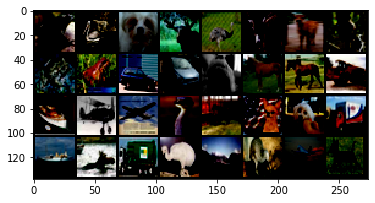

<IPython.core.display.Javascript object>

In [8]:
show_batch(train_dl)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

<IPython.core.display.Javascript object>

In [10]:
callbacks = [
    instantiate(cfg.callbacks.early_stopping),
    instantiate(cfg.callbacks.model_checkpoint),
    instantiate(cfg.callbacks.scheduler),
]

metrics = [instantiate(cfg.metric)]

<IPython.core.display.Javascript object>

In [11]:
exp = Experiment(**cfg.experiment.constant_params)

<IPython.core.display.Javascript object>

In [12]:
exp.compile_experiment(
    model=Net(), callbacks=callbacks, metrics=metrics, **cfg.experiment.compile_params
)

<IPython.core.display.Javascript object>

In [14]:
exp.fit_loader(train_dl=train_dl, valid_dl=valid_dl)


Epoch: 1/5
Train: 875/875 [=========================]- 247s 283ms/step - train_loss: 1.8848 - train_accuracy: 0.3133
Valid: 375/375 [=========================]- 96s 256ms/step - val_loss: 1.7359 - val_accuracy: 0.3312

Epoch: 2/5
Train: 875/875 [=========================]- 11s 13ms/step - train_loss: 1.6204 - train_accuracy: 0.3641
Valid: 375/375 [=========================]- 4s 10ms/step - val_loss: 1.5809 - val_accuracy: 0.3740

Epoch: 3/5
Train: 875/875 [=========================]- 11s 13ms/step - train_loss: 1.5147 - train_accuracy: 0.3937
Valid: 375/375 [=========================]- 4s 11ms/step - val_loss: 1.4786 - val_accuracy: 0.4010

Epoch: 4/5
Train: 875/875 [=========================]- 12s 13ms/step - train_loss: 1.4353 - train_accuracy: 0.4161
Valid: 375/375 [=========================]- 4s 11ms/step - val_loss: 1.4153 - val_accuracy: 0.4220

Epoch: 5/5
Train: 875/875 [=========================]- 12s 14ms/step - train_loss: 1.3652 - train_accuracy: 0.4346
Valid: 375/375 [====

<IPython.core.display.Javascript object>

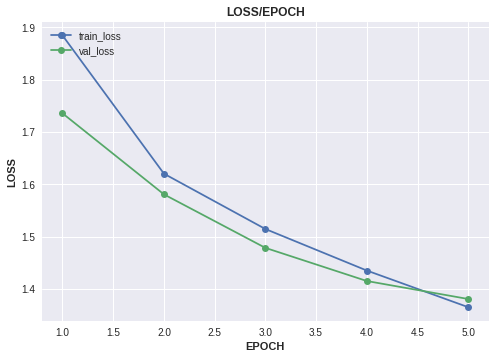

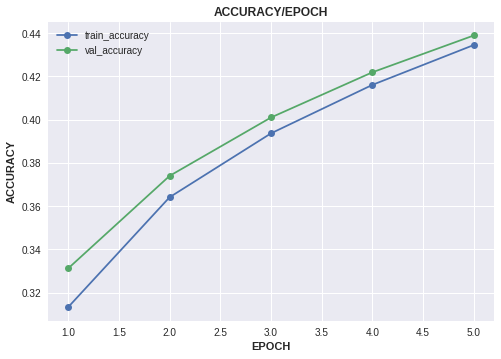

<IPython.core.display.Javascript object>

In [15]:
plot_metrics = ["loss", "accuracy"]

exp.plot_history(keys=plot_metrics, save_fig=False, plot_fig=True)